# TP1 de TSIA201 de Rayane Dakhlaoui 

# Practical work on the Conversion of sampling frequency and STFT


*From R. Badeau and G. Richard (with help from P. Vernhet), MAJ:2020*

**python version : 3.6**

In [ ]:
import os, sys, wave, struct

import numpy as np
from IPython.display import display, Image, Audio
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal
from time import time

from copy import deepcopy
from math import ceil
from scipy.io.wavfile import write

## Functions

In [ ]:
def load_sound(file):
    return wave.open(file, 'rb')


def play_sound(file, chunk = 1024):
    """
    Script from PyAudio doc
    """
    wf = load_sound(file)
    p = pyaudio.PyAudio()
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)
    data = wf.readframes(chunk)

    while data:
        stream.write(data)
        data = wf.readframes(chunk )

    stream.stop_stream()
    stream.close()
    p.terminate()
    
    
def plot_sound(data, times, name='default_name', save=False):
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()

## Reading and playing .wav file

Choose the name of sound for the rest of the notebook. Sounds are assumed to be set in a folder named 'sons_mutltipitch' (same directory as notebook).

In [ ]:
data_path = os.getcwd()
filename = 'caravan_48khz.wav'
sound = os.path.join(data_path, filename) 

### **Using wave**

In [ ]:
wavefile = load_sound(sound)
print(wavefile.getparams())

In [ ]:
play = False
if play :
    play_sound(sound) 

In [ ]:
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
x = np.array(data)


In [ ]:
timestep = 1/float(Fs)
times = np.arange(len(x))*timestep

In [ ]:
plot_sound(x, times)

In [ ]:
write('new_caravan.wav', Fs, np.array(x, dtype=np.int16)) # to write a new wave file

## 1. Conversion of sampling rate


### Question 1

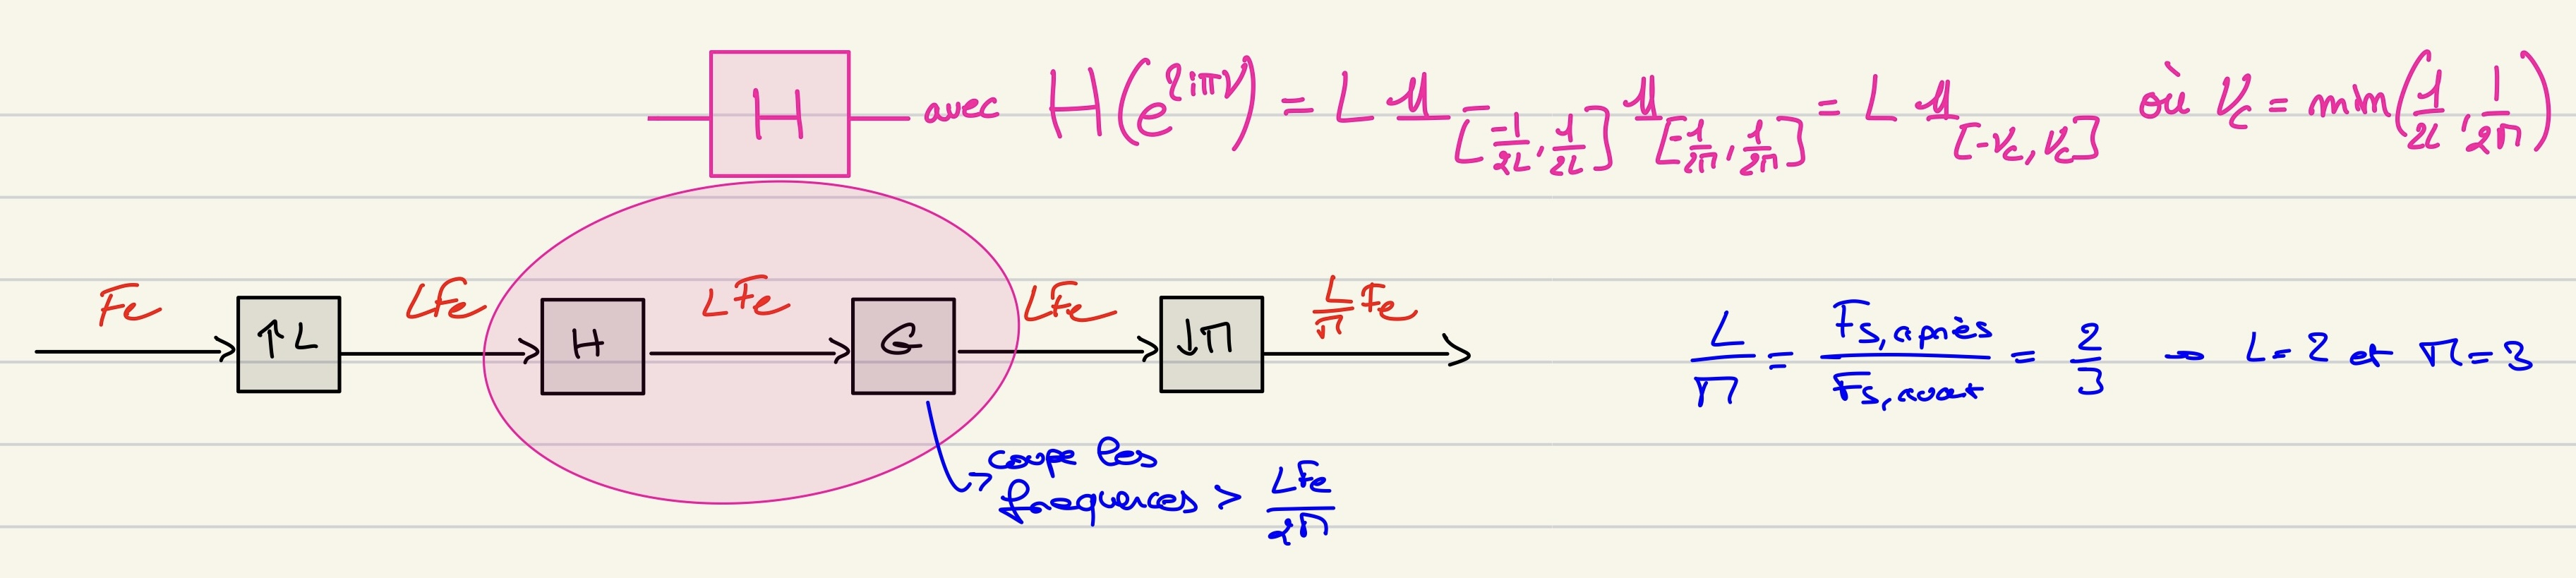

### Question 2

In [ ]:
#Constantes 
even_length = 256
nu_c = 1/6
epsilon = 0.035 #Obtenu en tatonant et ce en faisant attention à la convergence de l'algo de Remez 
L = 2

# Implémentation du filtre par la methode de Remez
h = scipy.signal.remez(even_length, [0, nu_c, nu_c + epsilon, 0.5], [L, 0])

# Calcul de la FFT du filtre
H = np.fft.fft(h, even_length)
H_dB = 20 * np.log10(np.abs(H))

# Affichage de la réponse en fréquence
plt.plot(H_dB)
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Amplitude (dB)')
plt.title('Réponse en fréquence')
plt.show()


### Question 3

In [ ]:
upsampled = np.zeros(len(x)*2)
for i in range(len(x)):
    upsampled[2*i] = x[i]
    upsampled[2*i+1] = 0
filtred_x = scipy.signal.lfilter(h, 1, upsampled)
downsampled = filtred_x[::3]

# Affichage du signal upsampled
times = np.arange(len(downsampled)) *(1/(Fs*2/3))
plot_sound(downsampled, times)
print("Audio Original:")
display(Audio(data=x, rate=Fs))

print("Audio Resampled:")
display(Audio(data=downsampled, rate=Fs*2/3))

### Question 4


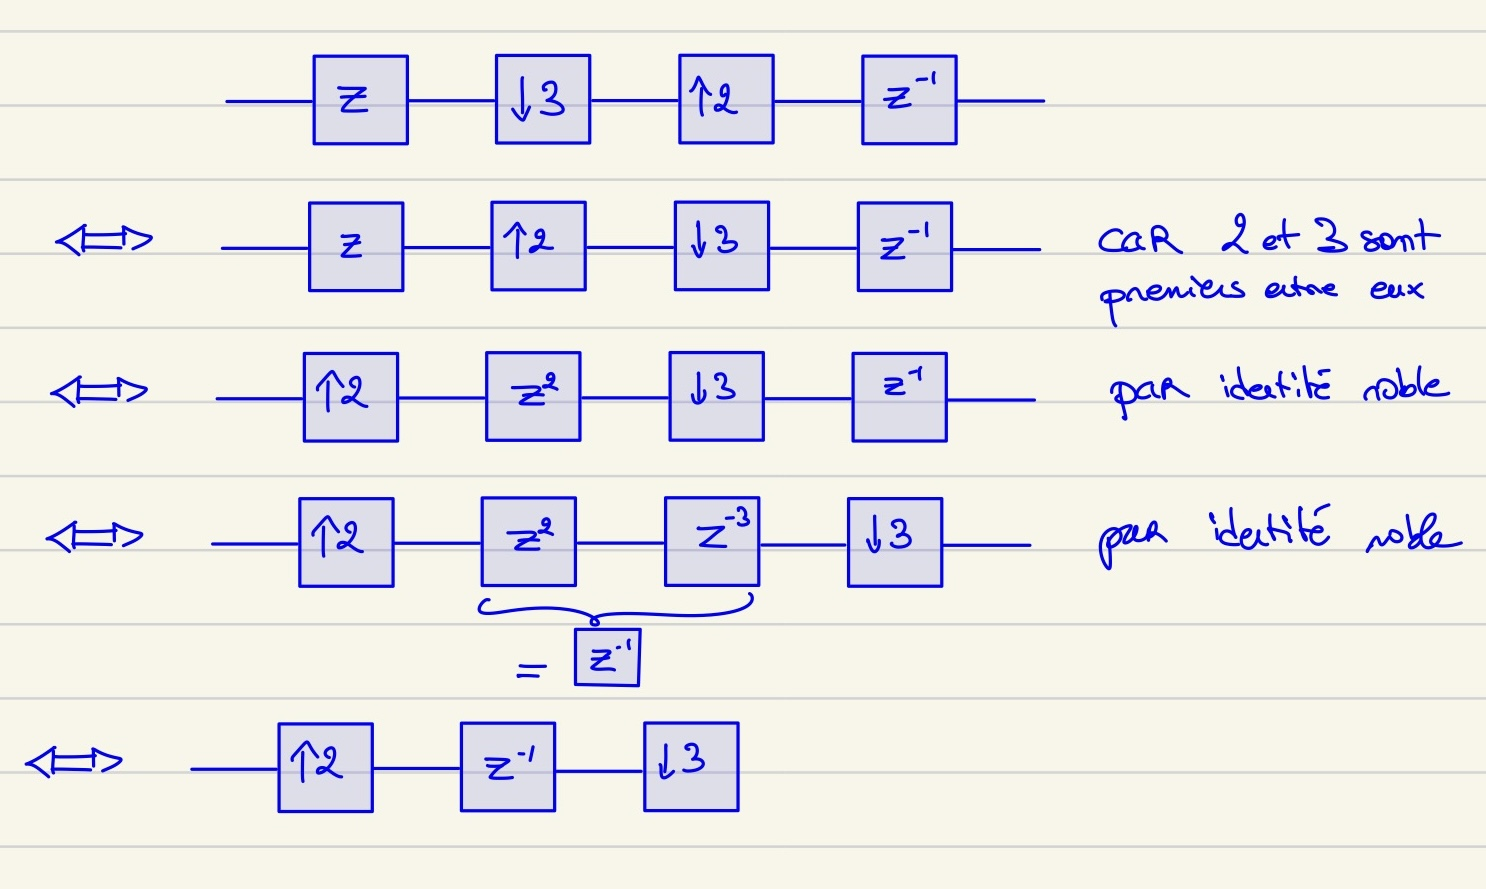

### Question 5
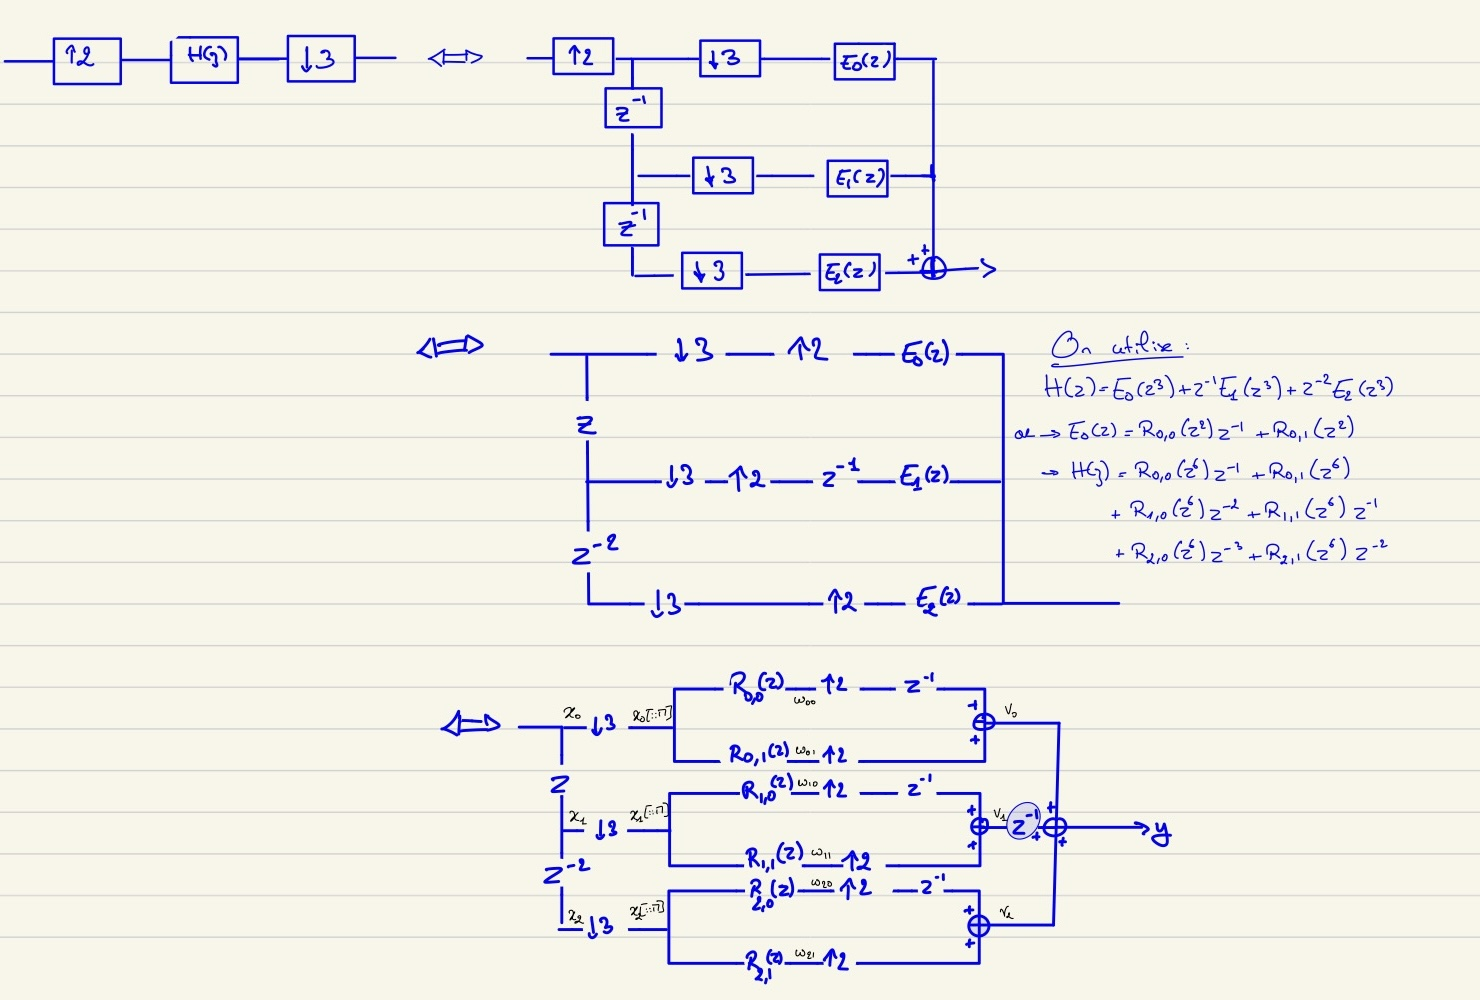

In [ ]:
def zeros_insertions(x,L):
	w=np.zeros(x.shape[0]*L)
	w[::L] = x
	return w


def efficient_ressampling(x, h, L = 2 , M = 3):
    x0 = x[::M]
    x1 = np.roll(x, -1)[::M]
    x2 = np.roll(x, 1)[::M]
    
    e0 = h[::M]
    e1 = np.roll(h, 1)[::M]
    e2 = np.roll(h, 2)[::M]
    
    r00 = np.roll(e0,1)[::L]
    r01 = e0[::L]
    
    r10 = np.roll(e1,1)[::L]
    r11 = e1[::L]
    
    r20 = np.roll(e2,1)[::L]
    r21 = e2[::L]
    
    w00 = scipy.signal.lfilter(r00, [1], x0)
    w01 = scipy.signal.lfilter(r01, [1], x0)
    w10 = scipy.signal.lfilter(r10, [1], x1)
    w11 = scipy.signal.lfilter(r11, [1], x1)
    w20 = scipy.signal.lfilter(r20, [1], x2)
    w21 = scipy.signal.lfilter(r21, [1], x2)
    
    v0 = np.roll(zeros_insertions(w00, L), 1) + zeros_insertions(w01, L)
    v1 = np.roll(zeros_insertions(w10, L), 1) + zeros_insertions(w11, L)
    v2 = np.roll(zeros_insertions(w20, L), 1) + zeros_insertions(w21, L)
    
    return v0 + np.roll(v1, 1) + v2

y_eff=efficient_ressampling(x, h)
print("Audio Original:")
plot_sound(x, np.arange(len(x))*timestep,'original')
print("Direct implementation of this conversion of sampling frequency:")
plot_sound(downsampled, np.arange(len(downsampled))*timestep*3/2,'resampled')
print("Optimal implementation of this conversion of sampling frequency:")
plot_sound(y_eff, np.arange(len(y_eff))*timestep*3/2,'efficient_resampled')

### Question 6

In [ ]:
nb_simulations = 10

simple_start = time()
for i in range(nb_simulations):
    downsampled = scipy.signal.lfilter(h, 1, upsampled)[::3]
delta_simple = (time() - simple_start)/nb_simulations

efficient_start = time()
for i in range(nb_simulations):
    y_eff=efficient_ressampling(x, h)
delta_efficient = (time() - efficient_start)/nb_simulations

print("Temps moyen pour la méthode simple : ", delta_simple)
print("Temps moyen pour la méthode optimale : ", delta_efficient)
print("Gain de temps : ", abs(delta_simple-delta_efficient)/max(delta_simple,delta_efficient)*100, "%")

## Signal analysis with the STFT

In [ ]:
N = x.shape[0] # % longueur du signal
Nw = 256 # % longueur de la fenetre de Hann
w = np.hanning(Nw) # définition de la fenetre de Hann
ws = w.copy; # définition de la fenêtre de synthèse
R = Nw/4 # incrément sur les temps d'analyse, appelé hop size, t_a=uR
M = Nw*2 # ordre de la tfd
L = int(M/2+1)
affich = 1 ; # pour affichage du spectrogramme, 0 pour
             # pour faire analyse/modif/synthèse sans affichage
             # note: cf. spectrogram sous Matlab
Nt = np.rint((N - Nw) / R) # calcul du nombre de tfd à calculer
Nt = Nt.astype(int)
y = np.zeros((N,1)) # signal de synthèse

if affich:
    Xtilde = np.zeros((M,Nt),dtype=complex)

In [ ]:
for u in np.arange(0,Nt).reshape(-1): # boucle sur les trames
    deb = u * R + 1 # début de trame
    fin = deb + Nw # fin de trame
    tx = np.multiply(x[np.arange(deb.astype(int),fin.astype(int))],w) # calcul de la trame 
    X = np.fft.fft(tx,M) # tfd à l'instant b
    if affich:
        Xtilde[:,u] = X
    # opérations de transformation (sur la partie \nu > 0)
    # ....
    Y = X.copy
    # fin des opérations de transformation
    # resynthèse
    # overlap add

def extents(f):
  delta = f[1] - f[0]
  return [f[0] - delta/2, f[-1] + delta/2]

In [ ]:
if affich:
    plt.imshow(20*np.log10(np.abs(Xtilde[np.arange(0,L),:])), aspect='auto',interpolation='none',origin='lower', extent=[0, Nt * R / Fs + Nw / 2, 0, Fs/2])

# 2. STFT audio equalization

## 2.1 STFT analysis

### Question 1

In [ ]:
# w est déjà défini comme la fenêtre de Hann
# Plot de la DFT de w
w_tfd = np.fft.fft(w,M)
w_shiffted = np.fft.fftshift(w_tfd)
freqs = np.fft.fftfreq(M)
freqs_shiffted = np.fft.fftshift(freqs)
plt.figure(figsize=(20, 10))
plt.plot(freqs_shiffted,20*np.log10(np.abs(w_shiffted)/np.max(np.abs(w_shiffted))))
plt.title('DFT of w')
plt.xlabel('Frequency normalized')
plt.show()


#### Largeur du the main lobe = 4/Nw

### Question 2
#### => Le spectre de la fenêtre de Hann s'apparente à celui d'un filtre passe bas. Avec la convention passe bas on décale le spectre de x de λ vers la gauche. On filtre donc avec la première forme de la STFT x autour de λ. Elle correspond donc à un FIR de Type 1 ou 2 car elle est symétrique. Ça sera un Type 1 sa longueur est impaire et un Type 2 si sa longueur est paire. Ici Nw est paire c'est donc un Type 2.

### Question 3
#### => L'expression X(λ,b) représente une version de la STFT où le filtre est décalé de λ vers la droite. C'est donc la deuxième expression sur le PDF est implémentée dans ce notebook.


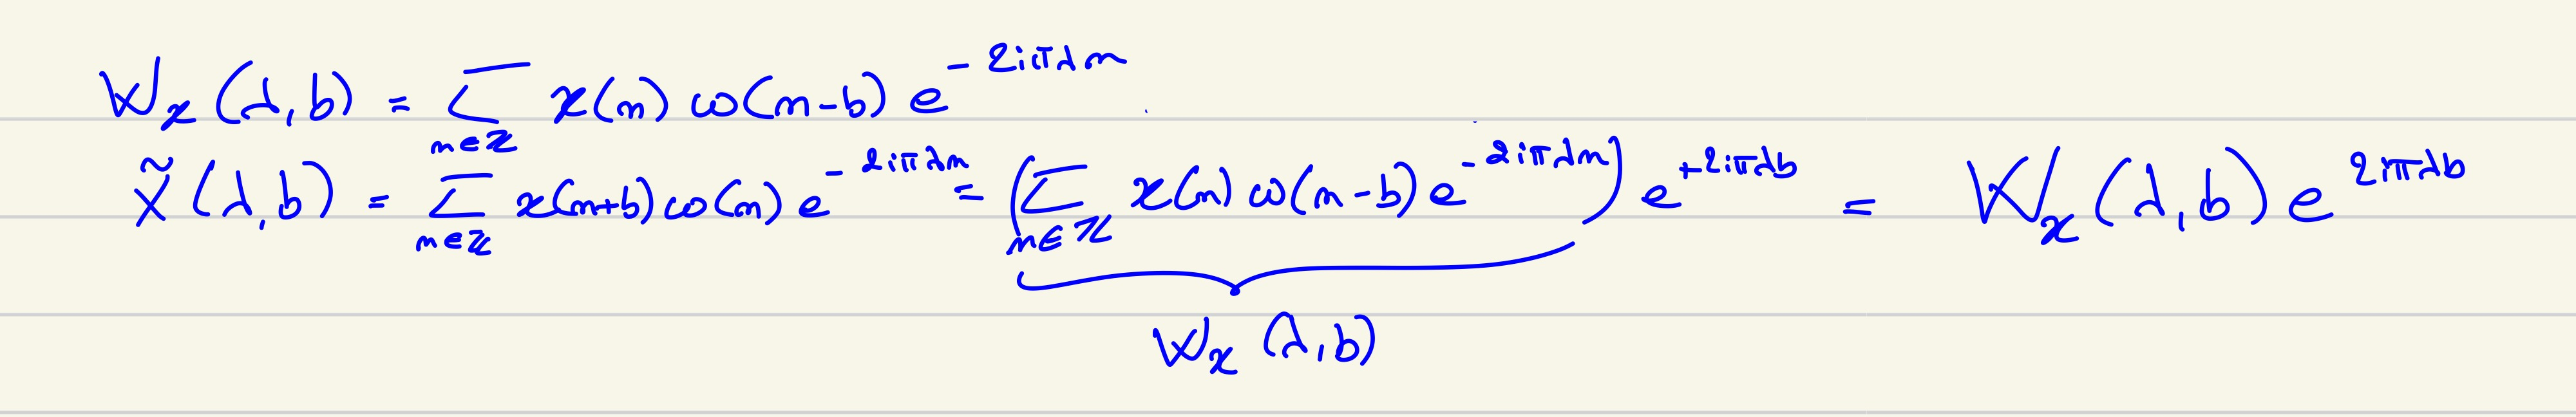

### Question 4

In [ ]:
#Constantes
k = 3
R_ = 1
M_ = 32
Nw_ = 16

# Fonction de calcul de la STFT
def stft(x, Nw, M, R, k):
    N = x.shape[0]  # % longueur du signal
    w = np.hanning(Nw)  # définition de la fenetre de Hann
    Nt = int(np.rint((N - Nw) / R))  # calcul du nombre de tfd à calculer
    Xtilde = np.zeros((M, Nt), dtype=complex)  # Spectre en fréquence
    for u in range(Nt):  # boucle sur les trames
        deb = u * R # début de trame
        fin = deb + Nw # fin de trame
        tx = x[deb:fin] * w  # calcul de la trame 
        X = np.fft.fft(tx, M) # tfd à l'instant b
        Xtilde[:, u] = X
    xk_u = Xtilde[k, :] 
    
    return xk_u, Xtilde


xk_u, Xtilde = stft(x, Nw_, M_, R_, k)

# Affichage de xk(u) pour k=3
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(np.abs(xk_u))
plt.title(f'Amplitude de xk(u) pour k={k}')
plt.tight_layout()
plt.show()

#Est ce que xk(u) est complexe ?
is_complex = np.iscomplexobj(xk_u)
has_imaginary_part = np.any(np.imag(xk_u) != 0)
print(f"x_k(u) est complexe: {is_complex}")
print(f"x_k(u) a une partie imaginaire: {has_imaginary_part}")

if has_imaginary_part:
    print("Partie réelle de x_k(u):", np.real(xk_u))
    print("Partie imaginaire de x_k(u):", np.imag(xk_u))
else:
    print("x_k(u) est un signal réel.")

#Affichage du spectrogramme et du signal Re(xk(u))
scipy.signal.lfilter(w, 1, xk_u)
scipy.signal.spectrogram(x, fs=Fs, window='hann', nperseg=Nw_, noverlap=Nw_//2, nfft=M_, mode='complex')
print("Audio de Re(x_k):")
Audio(data=np.real(xk_u), rate=48000)

## Overlap-add reconstruction

In [ ]:
def ola(w = None,hop = None,Nb = 10): 
# function output = ola(w,hop,Nb)
# realise l'addition-recouvrement de la fenetre w,
# avec un décalage hop et un nombre Nb de fenetres.
# par defaut Nb = 10;
    w = w[:, np.newaxis]
    N = len(w)
    output = np.zeros(((Nb - 1) *int(hop) + N,1)) # réserve l'espace memoire
    
    for k in np.arange(0,Nb).reshape(-1):
        deb = int(k * hop)
        fin = deb + N
        output[np.arange(deb,fin)] = output[np.arange(deb,fin)] + w # OLA
    
    return output

### Question 5
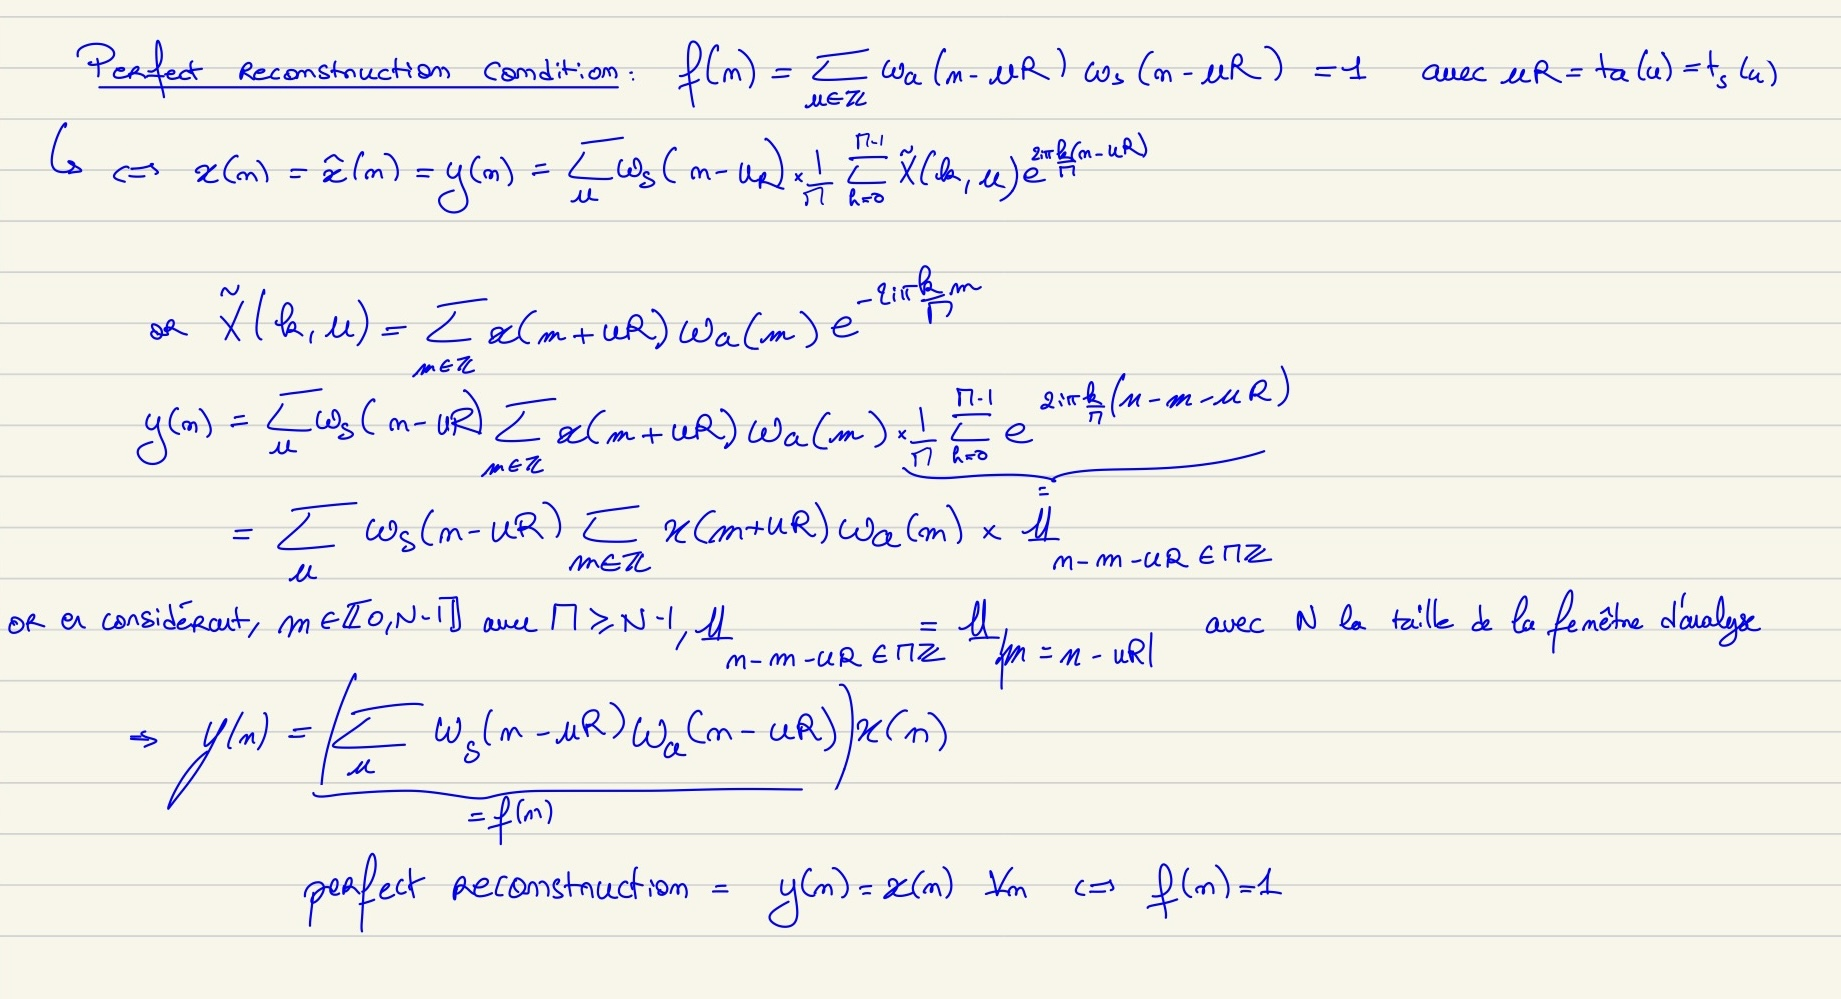

In [ ]:
def normalisation(x):
    s = 0
    for i in range(len(x)):
        s += x[i]**2
    return np.multiply(x,1/np.sqrt(s))

Nw = 512
hop = int((1-75/100)*Nw)
Nb = int(N/hop)
h = np.hanning(Nw)
h_normalisé = normalisation(h)
w_p = np.multiply(h_normalisé,h_normalisé)*hop

ola_output = ola(w_p, hop, Nb)
plt.plot(ola_output)
plt.title('OLA output')



### Question 6

In [ ]:
y_ola = np.multiply(ola_output[len(x):],x)
print("Audio Original:")
display(Audio(data=x, rate=Fs))
print("Resynthesis according to the overlap-add approach:")
display(Audio(data=y_ola[0,:], rate=Fs))

